In [1]:
import sys, os
import time, random, pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'
%matplotlib inline

In [2]:
xgb.__version__

'1.2.0'

### Prepare_data

In [3]:
train = pd.read_csv('../dataset/train_set.csv')
val = pd.read_csv('../dataset/validation_set.csv')
test = pd.read_csv('../dataset/test_set.csv') ##CASF-2016 core set

train['delta'] = train['pKd'] - train['Lin_F9']
val['delta'] = val['pKd'] - val['Lin_F9']
test['delta'] = test['pKd'] - test['Lin_F9']

In [4]:
len(train), len(val), len(test)

(21943, 1578, 285)

In [5]:
LigandDescriptors = ['HeavyAtomMolWt', 'NumValenceElectrons','FpDensityMorgan1', 
                     'FpDensityMorgan2', 'FpDensityMorgan3', 'LabuteASA',
                     'TPSA', 'NHOHCount', 'NOCount','MolLogP','MolMR'] #

LigandDescriptors = [x for x in LigandDescriptors if x not in ['NOCount']]
len(LigandDescriptors)

10

In [6]:
f_type = ["P","N","DA","D","A","AR","H","PL","HA","SA"]
SASA = ["P2." + i for i in f_type] + ["P2dl." + i for i in f_type] + ["P2dp." + i for i in f_type]
SASA = [x for x in SASA if x not in ['P2dl.HA','P2dp.HA']]
BW = ["Nbw","Epw","Elw"]

vina1 = ['vina%d'%x for x in range(2,9)]
vina2 = ['vina%d'%x for x in range(10,17)]
vina3 = ['vina%d'%x for x in range(18,25)]
vina4 = ['vina%d'%x for x in range(26,31)]
vina5 = ['vina%d'%x for x in range(32,37)]
vina6 = ['vina%d'%x for x in range(38,49)]

vina=vina1+vina2+vina3+vina4+vina5+vina6

metal = ['metal%d'%x for x in range(2,8)]

columns = vina+['ligCover','betaScore','LE']+SASA+metal+LigandDescriptors+BW
len(columns)

92

In [7]:
X_train = np.c_[train[columns]]
y_train = np.c_[train[['delta']]]
X_train = X_train.astype(np.float64)
y_train_fix = np.r_[train['Lin_F9']]
y_train_const = np.r_[train['pKd']]

X_val = np.c_[val[columns]]
y_val = np.c_[val[['delta']]]
X_val = X_val.astype(np.float64)
y_val_fix = np.r_[val['Lin_F9']]
y_val_const = np.r_[val['pKd']]

X_test = np.c_[test[columns]]
y_test = np.c_[test[['delta']]]
X_test = X_test.astype(np.float64)
y_test_fix = np.r_[test['Lin_F9']]
y_test_const = np.r_[test['pKd']]

### run XGB model

In [8]:
def Get_rank(df):
    Spearman_list, Kendall_list, target, pdb = [], [], [], []
    ss = pd.read_csv('CASF-2016.csv')
    for i in range(1,58):
        sa = ss.loc[ss['target']==i]
        target.append(i)
        pdb.append(sa.pdb.tolist())
        de = df.loc[df['pdb'].isin(sa.pdb.tolist())]
        Spearman_list.append(round(stats.spearmanr(de['XGB'], de['pKd'])[0],3))
        Kendall_list.append(round(stats.kendalltau(de['XGB'], de['pKd'])[0],3))
    return np.mean(Spearman_list), np.mean(Kendall_list)

def Get_evaluation(y_test_const, y_test_predict, y_test_fix):
    print("Mean squared error: %.3f"%np.sqrt(mean_squared_error(y_test_const,y_test_predict+y_test_fix)))
    print('Mean absolute error: %.3f'%mean_absolute_error(y_test_const, y_test_predict+y_test_fix))
    print ('pearsonr:', (stats.pearsonr(y_test_const.ravel(), y_test_predict+y_test_fix)))
    print ('spearmanr:', (stats.spearmanr(y_test_const, y_test_predict+y_test_fix)))
    print ('kendall:', (stats.kendalltau(y_test_const, y_test_predict+y_test_fix)))
    print (len(y_test_predict))

#### 1. Training set performance

In [9]:
y_train_predict_ = []
for i in range(1,11):
    xgb_model = pickle.load(open("../saved_model/mod_%d.pickle.dat"%i,"rb"))
    y_train_i_predict = xgb_model.predict(X_train, ntree_limit=xgb_model.best_ntree_limit)
    y_train_predict_.append(y_train_i_predict)

y_train_predict = np.average(y_train_predict_, axis=0)

In [10]:
Get_evaluation(y_train_const, y_train_predict, y_train_fix)

Mean squared error: 0.051
Mean absolute error: 0.035
pearsonr: (0.9998471694297933, 0.0)
spearmanr: SpearmanrResult(correlation=0.9998248108567666, pvalue=0.0)
kendall: KendalltauResult(correlation=0.9899940387062343, pvalue=0.0)
21943


#### 2. Validation set performance

In [11]:
y_val_predict_ = []
for i in range(1,11):
    xgb_model = pickle.load(open("../saved_model/mod_%d.pickle.dat"%i,"rb"))
    y_val_i_predict = xgb_model.predict(X_val, ntree_limit=xgb_model.best_ntree_limit)
    y_val_predict_.append(y_val_i_predict)

y_val_predict = np.average(y_val_predict_, axis=0)

In [12]:
Get_evaluation(y_val_const, y_val_predict, y_val_fix)

Mean squared error: 1.448
Mean absolute error: 1.146
pearsonr: (0.7888132520408538, 0.0)
spearmanr: SpearmanrResult(correlation=0.7846378355011225, pvalue=0.0)
kendall: KendalltauResult(correlation=0.5908678290108726, pvalue=8.703285646107665e-270)
1578


#### 3. Test performance (CASF-2016 benchmark)

In [13]:
y_test_predict_ = []
for i in range(1,11):
    xgb_model = pickle.load(open("../saved_model/mod_%d.pickle.dat"%i,"rb"))
    y_test_i_predict = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)
    y_test_predict_.append(y_test_i_predict)

y_test_predict = np.average(y_test_predict_, axis=0)

In [14]:
Get_evaluation(y_test_const, y_test_predict, y_test_fix)

Mean squared error: 1.240
Mean absolute error: 0.967
pearsonr: (0.8452735115990057, 5.236674331721536e-79)
spearmanr: SpearmanrResult(correlation=0.8426996683128004, pvalue=4.450761495306719e-78)
kendall: KendalltauResult(correlation=0.6532766452960354, pvalue=1.2726079010484372e-60)
285


In [15]:
test['XGB'] = pd.Series(y_test_predict+y_test_fix, index=test.index)

In [16]:
Get_rank(test)

(0.7035087719298247, 0.6245614035087719)

In [17]:
test['delta1'] = abs(test['XGB']-test['pKd'])
len(test.loc[test['delta1']>2])

26

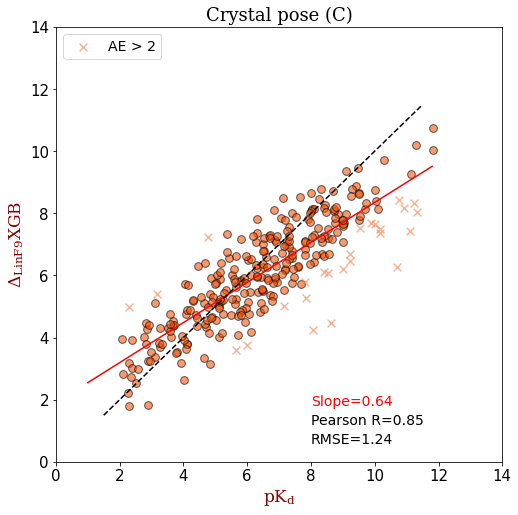

In [18]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(np.c_[test['pKd']], np.c_[test['XGB']])
a0 = lm.intercept_
a1 = lm.coef_[0]
X1 = np.arange(1,12,0.2)
Y1 = a0 + a1*X1

test1 = test.loc[test['delta1']<=2]
test2 = test.loc[test['delta1']>2]
plt.figure(figsize=[8,8])
plt.scatter(test1['pKd'], test1['XGB'],s=60,edgecolors='k', alpha=0.6, color='#F5560E')
plt.scatter(test2['pKd'], test2['XGB'],s=60, edgecolors='k',alpha=0.6, color='#F28350',label='AE > 2',marker='x')
plt.plot(X1,Y1, color='r')
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 18,
        }
plt.xlabel(r'pK$_d$', fontdict=font)
plt.ylabel(r'$\Delta_{LinF9}$XGB', fontdict=font)
plt.xlim(0,14)
plt.ylim(0,14)
plt.plot(np.arange(1.5,12), np.arange(1.5,12), color='k',linestyle = 'dashed')
plt.title('Crystal pose (C)', fontdict=font1)
plt.text(8,1.8,'Slope=%.2f'%a1, fontsize=14, color='r')
plt.text(8,1.2,'Pearson R=0.85', fontsize=14, color='k')
plt.text(8,0.6,'RMSE=1.24', fontsize=14, color='k')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=14)
#plt.savefig('/home/cyang/job/XGB_figure/scatter/fig1D.png',dpi=400, format='png',bbox_inches='tight')